## Project: Finding Donors for *CharityML*

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [21]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline
seed = 0
# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


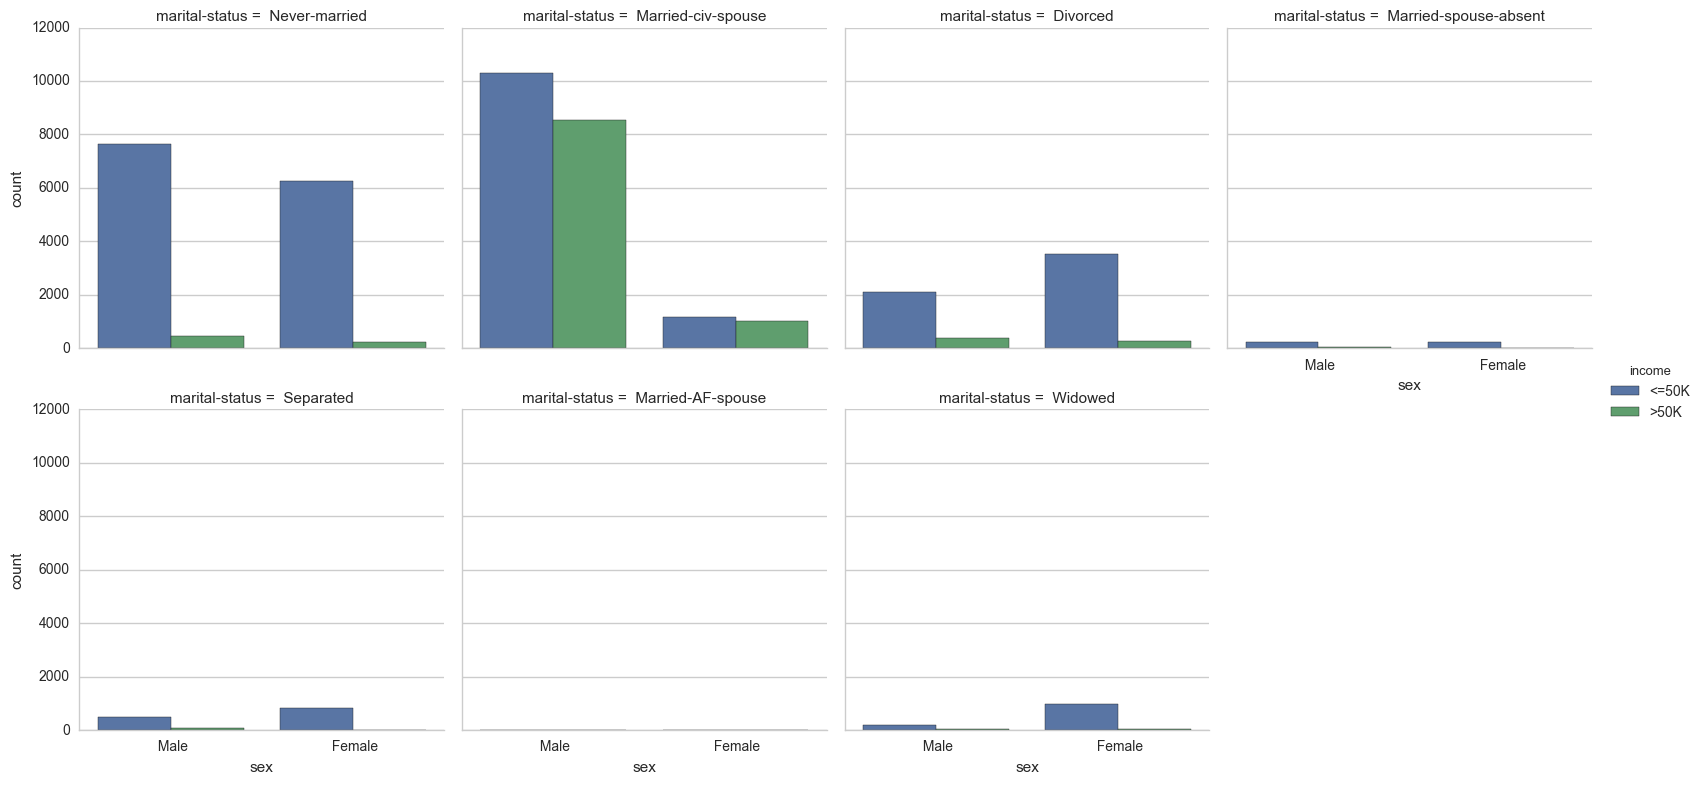

In [22]:
sns.set(style="whitegrid", color_codes=True)
sns.factorplot("sex", col="marital-status", data=data, hue='income', kind="count", col_wrap=4);

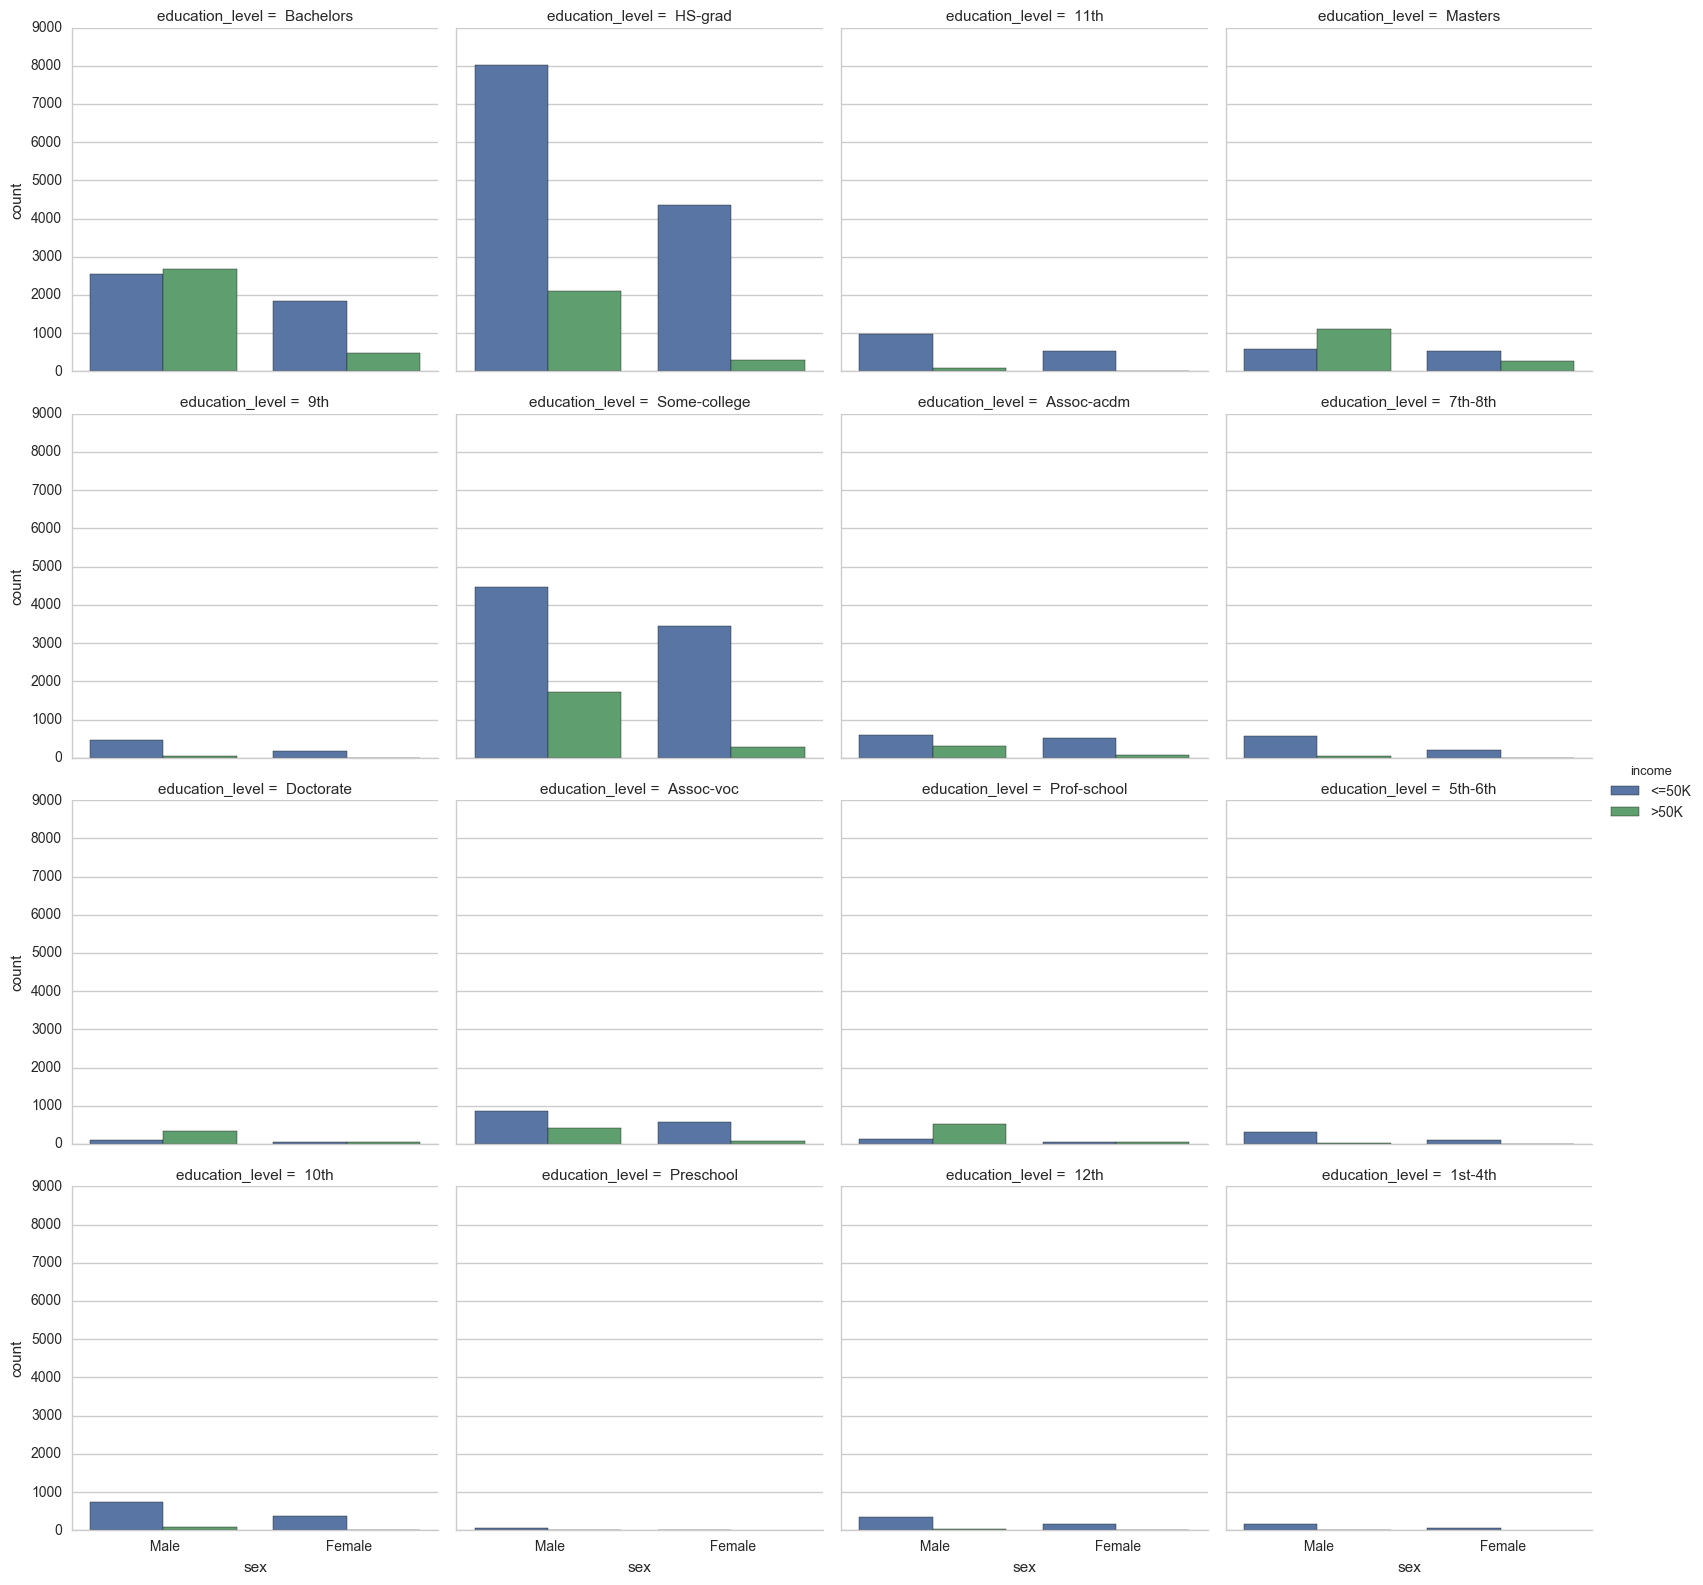

In [23]:
sns.factorplot("sex", col="education_level", data=data, hue='income', kind="count", col_wrap=4);

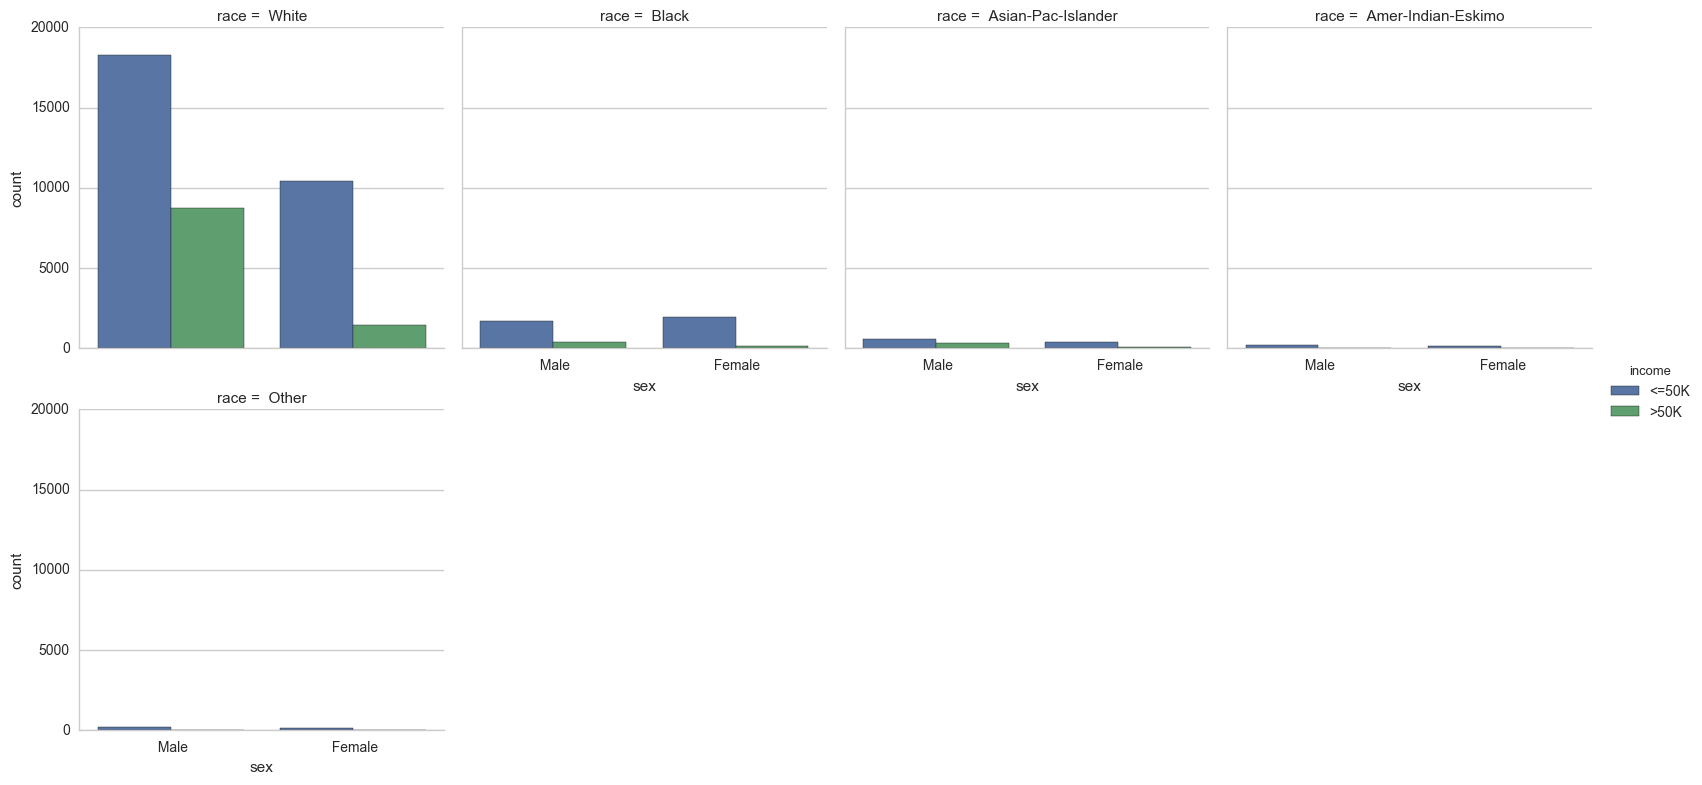

In [24]:
sns.factorplot("sex", col="race", data=data, hue='income', kind="count", col_wrap=4);

### Implementation: Data Exploration

In [25]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'].eq('>50K')].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'].eq('<=50K')].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)/n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [26]:
# number of non-numeric feature
for col in data.columns:
    if data[col].dtype == 'O':
        display(data[col].value_counts())

 Private             33307
 Self-emp-not-inc     3796
 Local-gov            3100
 State-gov            1946
 Self-emp-inc         1646
 Federal-gov          1406
 Without-pay            21
Name: workclass, dtype: int64

 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education_level, dtype: int64

 Married-civ-spouse       21055
 Never-married            14598
 Divorced                  6297
 Separated                 1411
 Widowed                   1277
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital-status, dtype: int64

 Craft-repair         6020
 Prof-specialty       6008
 Exec-managerial      5984
 Adm-clerical         5540
 Sales                5408
 Other-service        4808
 Machine-op-inspct    2970
 Transport-moving     2316
 Handlers-cleaners    2046
 Farming-fishing      1480
 Tech-support         1420
 Protective-serv       976
 Priv-house-serv       232
 Armed-Forces           14
Name: occupation, dtype: int64

 Husband           18666
 Not-in-family     11702
 Own-child          6626
 Unmarried          4788
 Wife               2091
 Other-relative     1349
Name: relationship, dtype: int64

 White                 38903
 Black                  4228
 Asian-Pac-Islander     1303
 Amer-Indian-Eskimo      435
 Other                   353
Name: race, dtype: int64

 Male      30527
 Female    14695
Name: sex, dtype: int64

 United-States                 41292
 Mexico                          903
 Philippines                     283
 Germany                         193
 Puerto-Rico                     175
 Canada                          163
 El-Salvador                     147
 India                           147
 Cuba                            133
 England                         119
 China                           113
 Jamaica                         103
 South                           101
 Italy                           100
 Dominican-Republic               97
 Japan                            89
 Guatemala                        86
 Vietnam                          83
 Columbia                         82
 Poland                           81
 Haiti                            69
 Portugal                         62
 Iran                             56
 Taiwan                           55
 Greece                           49
 Nicaragua                        48
 Peru                             45
 

<=50K    34014
>50K     11208
Name: income, dtype: int64

----
## Preparing the Data

### Transforming Skewed Continuous Features


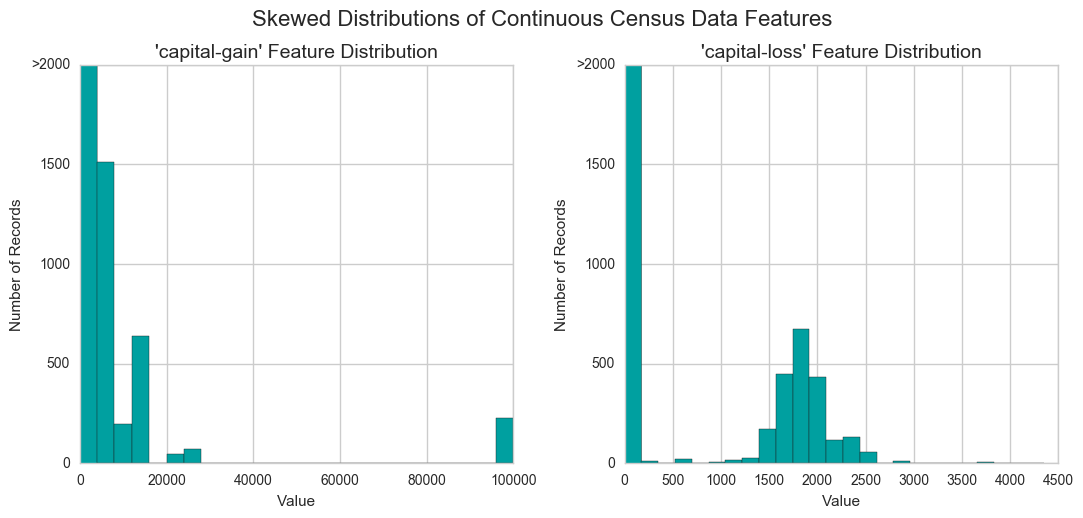

In [27]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

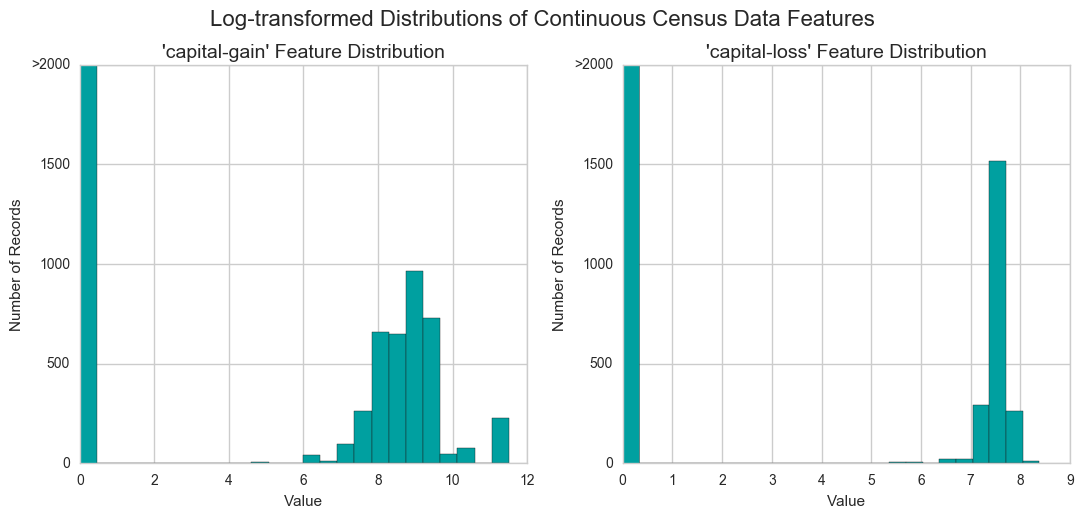

In [28]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features

In [29]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

In [30]:
# One-hot encode the 'features_raw' 
features = pd.get_dummies(features_raw)

#Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# encoded features
print encoded[:10]

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc']


### Shuffle and Split Data

In [31]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = seed)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


Training set has 36177 samples.
Testing set has 9045 samples.


----
## Feature Importance

### Feature Relevance Observation

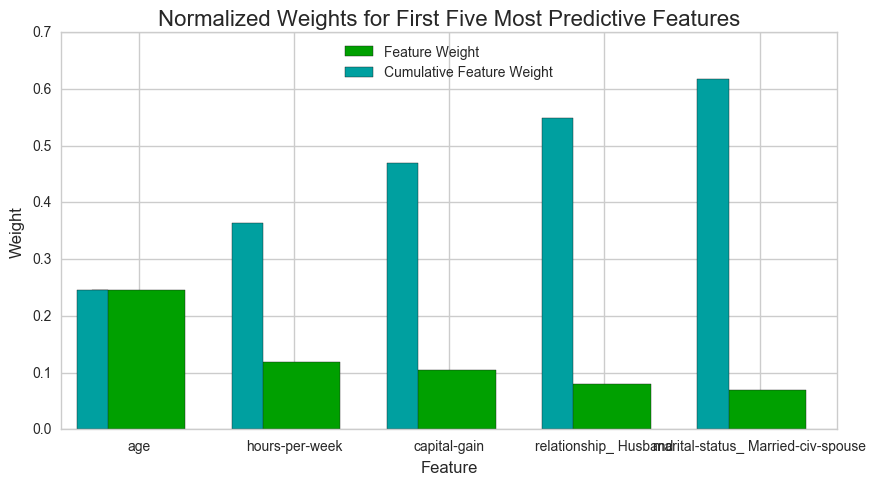

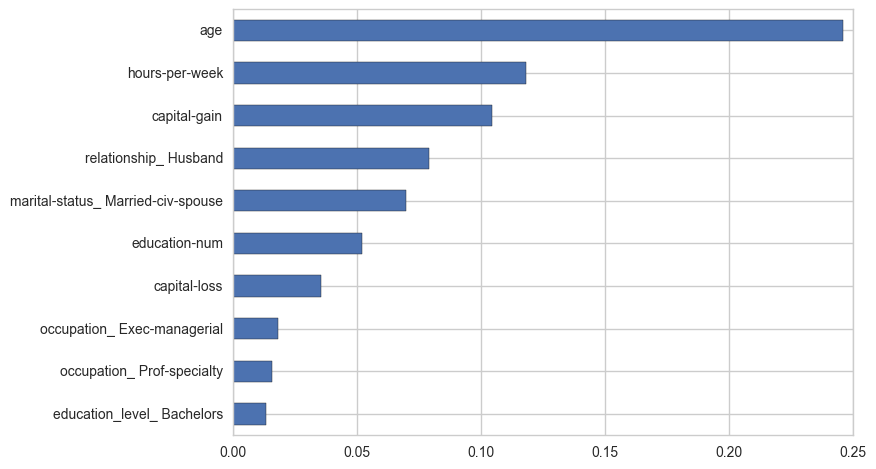

In [47]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier
# Train the supervised model on the training set 
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot features importance
vs.feature_plot(importances, X_train, y_train)

# top 10 features
n = 10
fi = model.feature_importances_
pd.Series(fi, index=X_train.columns).sort_values()[-n:].plot(kind='barh');

----
## Evaluating Model Performance

### Metrics and the Naive Predictor

In [32]:
# Calculate accuracy
accuracy = (float(n_greater_50k)/n_records)*100

# Calculate F-score using the formula above for beta = 0.5
precision = float(n_greater_50k)/n_records
recall = 1
beta_square = 0.25
fscore = (1 + beta_square)*(precision*recall)/(beta_square*precision + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 24.7844, F-score: 0.2917]


###  Supervised Learning Models
We will evaluate the following models.
- Gradient Boosting.
- Stochastic Gradient Descent Classifier.
- Logistic Regression.


- Logistic Regression:(ref: Section 4.3 Logistic Regression, page 130, An Introduction to Statistical Learning, 2014 )
	- Strengths:
		- Performs well for two classes classification.
		- Easy to implement.
		- Easy to understand.
	- Weaknesses:
		- Unstable when the classes are well-separated.
		- Unstable when the sample size is small and the distribution of the predictors is approximately normal.
		- Performs poorly when we have more than two classes.
    - Since the target variable of our problem is categorical and binary, this model is a good choice for our problem.

- Stochastic Gradient Descent Classifier:(ref: http://scikit-learn.org/stable/modules/sgd.html)
    - Strengths:
        - Efficient.
		- Ease of implementation (lots of opportunities for code tuning).
    - Weaknesses: 
        - Requires a number of hyper-parameters such as regularization parameter and the number of iterations.
		- Sensitive to feature scaling.
    - Since the target variable of our problem is categorical and binary, this model is a good choice for our problem.
- Gradient Boosting Classifier: (ref: http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)
	- Strengths:
        - Natural handling of data of heterogeneous features.
		- Predictive power.
		- Robustness to outliers in output space (via robust loss functions).
	
    - Weakness:
        - Scalability.
    - Since the target variable of our problem is categorical and binary, this model is a good choice for our problem.

### Implementation - Creating a Training and Predicting Pipeline

In [33]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    X_train_slice = X_train[0:sample_size]
    y_train_slice =  y_train[0:sample_size]
    
    #  Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train_slice, y_train_slice)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start 
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[0:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[0:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


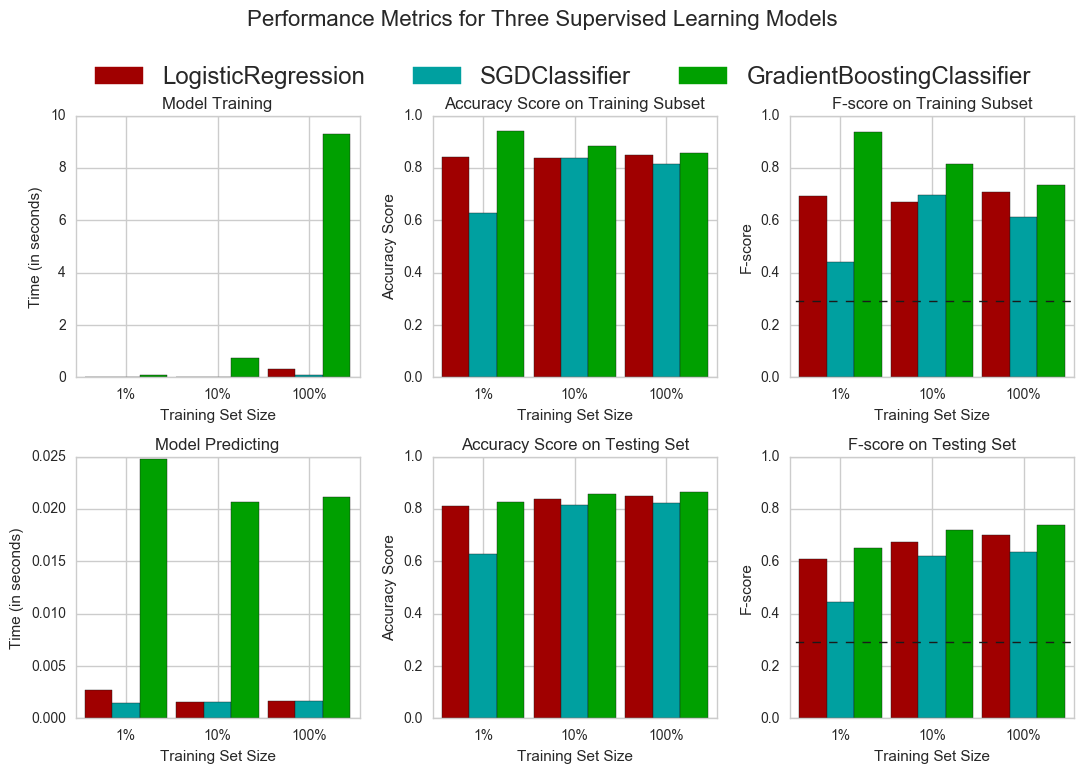

In [34]:
#Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier


# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = SGDClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
length = len(X_train)
samples_1 = length/100
samples_10 = length/10
samples_100 = length

#Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

###  Choosing the Best Model

The most appropriate model for the task is the gradient boosting classifier model. It has the highest accuracy score - 0.85 training and 0.86 testing - , f-score -  0.73 training and 0.73 testing -, training time - 9.6s - , and prediction time - 0.024s -. Since the goal of CharityML is to accurately predict a potential donor, it will be worth the trade off between speed and accuracy. 

### Gradient Boosting model in Layman's Terms

Gradient boosting combines several simple prediction models to create an "ensemble" of models that can make more accurate predictions. In our case, the model is trained with existing census data (e.g., age, gender, etc), and uses that data to find rules that separate those with income above or below 50K. During successive rounds of training, new rules (i.e., decision trees) are learned that essentially create a flowchart of yes/no questions that increase the ability of the model to make correct predictions. With each round, the model looks at where a learned tree predicted poorly and tries to increase their importance for the next round. The trees are then combined to create the final model, where the trees that do a better job of classifying are added to the model in the sequential order as they were created. Using this model trained with data of known individuals, the model can look at new unknown individuals and predict whether their income is above or below 50K.

### Implementation: Model Tuning

In [35]:

# Import 'GridSearchCV', 'make_scorer'
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=seed)

# Create the parameters list you wish to tune
parameters = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=4)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
best_params = grid_fit.best_params_


# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Best params: {} ".format(best_params)    
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Best params: {'n_estimators': 300} 
Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8699
Final F-score on the testing data: 0.7516


### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8630            | 0.8699          |
| F-score        | 0.2917              | 0.7395            | 0.7516          |


Our optimized model’s accuracy and F-score is 0.87 and 0.75 respectively, which is better than the unoptimized model - 0.86 accuracy and 0.73 F-score. Our optimized scores are better than the naive predictor with a difference in accuracy and F-score of 0.62 and 0.46 respectively.